In [1]:
%matplotlib notebook
#Ziyan Zhu
import numpy as np 
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import nntools as nt
from VOCdataset import VOCDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print(torch.__version__)

1.1.0


In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
color = {}
for i in range(len(labels)):    
    color[labels[i]] = np.random.random(3)
    
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    if type(boxes['boxes']) == 'torch.Tensor':
        boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
        boxes['labels'] = boxes['labels'].to('cpu').numpy()

    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],linewidth=1.5,facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 

    if len(scores) == 0:
        ax.axis('off')
        return h
    elif boxes.shape[0] > 0:
        for i in range(len(names)):
            ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],linewidth = 1.5, facecolor='none'))
            ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
        ax.axis('off')
    else:
        ax.gca().add_patch( patches.Rectangle((boxes[0],boxes[1]),boxes[2]- boxes[0],boxes[3]-boxes[1],edgecolor=color[labels[names]],linewidth = 1.5,facecolor='none'))
        ax.annotate(labels[names]+ ':' + str(scores), xy=(boxes[2], boxes[1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names]]))
        ax.axis('off') 
   
    return h

class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [6]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

# Load the model

In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
backbone = tv.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of output channels in a backbone. For vgg16, it's 512
backbone.out_channels = 1280
# let's make the RPN generate 5 x 3 anchors per spatial location, 
# with 5 different sizes and 3 different aspect ratios. 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# let's define what are the feature maps that we will use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
roi_pooler = tv.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
# put the pieces together inside a FasterRCNN model
model_mobnet = FasterRCNN(backbone,num_classes=21,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /tmp/xdg-cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 14212972/14212972 [00:00<00:00, 17686964.67it/s]


In [9]:
# ignore the pretrained part first
for param in model_mobnet.backbone.parameters():
    param.requires_grad = False
# create experience
lr = 1e-3
model_mobnet = model_mobnet.to(device)
params = [p for p in model_mobnet.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model_mobnet, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_mobnet_0", perform_validation_during_training=True)

In [10]:
def plot(exp, fig, axes): 
    axes.clear()
    axes.plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")
    axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes.legend()
    axes.set(xlabel = 'Epoch', ylabel = 'Loss')
    plt.tight_layout()
    fig.canvas.draw()

# Training 1

<IPython.core.display.Javascript object>


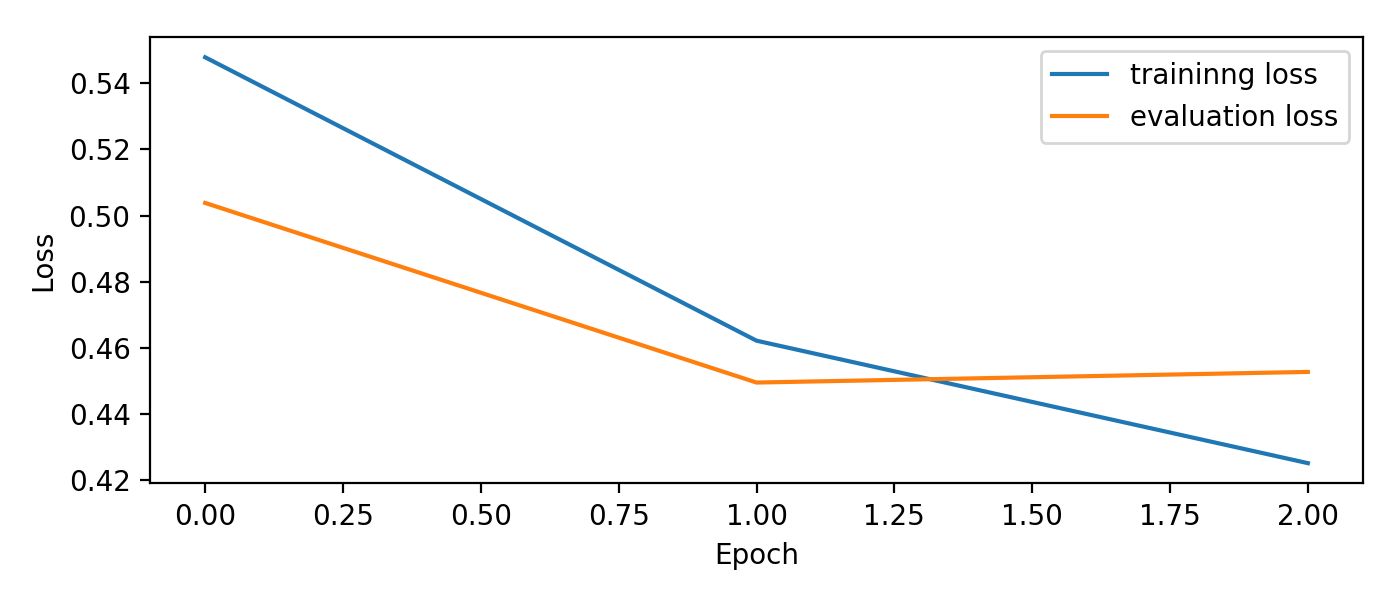

Start/Continue training from epoch 3
Finish training for 2 epochs


In [19]:
# 跑呀跑～加油跑
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=2, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [12]:
# Now train the pretrained part 
new_model = exp1.net
for param in new_model.backbone.parameters():
    param.requires_grad = True
# create experience
lr = 5e-4
new_model = new_model.to(device)
params = [p for p in new_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(new_model, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_mobnet", perform_validation_during_training=True)

# Training 2

<IPython.core.display.Javascript object>


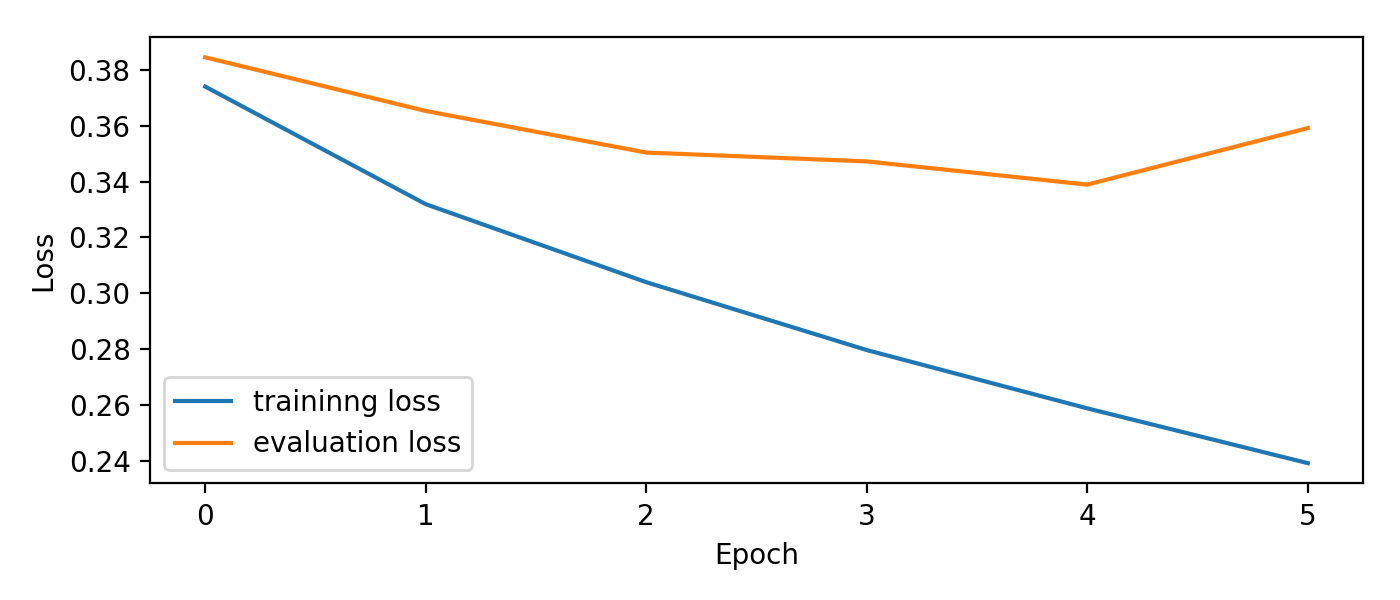

Start/Continue training from epoch 6
Finish training for 6 epochs


In [16]:
# 跑呀跑～加油跑
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp2.run(num_epochs=6, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<IPython.core.display.Javascript object>


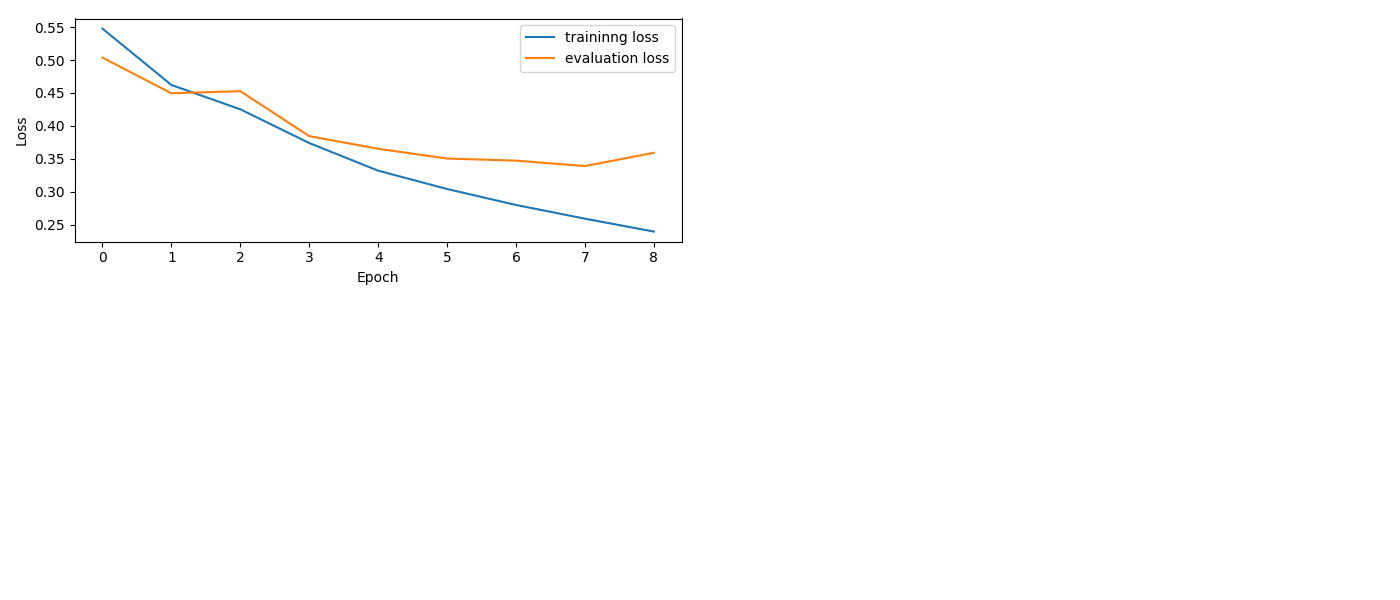

In [47]:
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
axes.clear()
train = [exp1.history[k][0]['loss'] for k in range(exp1.epoch)] + [exp2.history[k][0]['loss'] for k in range(exp2.epoch)]
val = [exp1.history[k][1]['loss'] for k in range(exp1.epoch)] + [exp2.history[k][1]['loss'] for k in range(exp2.epoch)]
axes.plot(train,
             label="traininng loss")
axes.plot(val,
             label="evaluation loss")

axes.legend()
axes.set(xlabel = 'Epoch', ylabel = 'Loss')
plt.tight_layout()
fig.canvas.draw()

# Testing the model

In [17]:
model = exp2.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(1105)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    prediction = model([images])
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp2.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.1)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp2.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.4)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
    

[{'boxes': tensor([[178.2762,   4.8538, 649.5811, 458.6304],
        [210.8402, 184.6570, 645.6735, 400.2023],
        [391.9055,  46.3420, 631.6948, 445.1730],
        [369.7027,  67.8359, 597.4037, 391.4597],
        [217.7462,   8.6328, 453.6328, 428.0875]], device='cuda:0'), 'labels': tensor([19, 19, 19, 14, 19], device='cuda:0'), 'scores': tensor([0.9972, 0.7670, 0.7607, 0.3268, 0.1402], device='cuda:0')}]
---------------------------------
{'boxes': tensor([[208.0000,  21.3333, 606.4000, 390.4000]], device='cuda:0'), 'labels': tensor([19], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[178.2762,   4.8538, 649.5811, 458.6304],
        [369.7027,  67.8359, 597.4037, 391.4597]], device='cuda:0'), 'scores': tensor([0.9972, 0.3268], device='cuda:0'), 'labels': tensor([19, 14], device='cuda:0', dtype=torch.int32)}


<IPython.core.display.Javascript object>


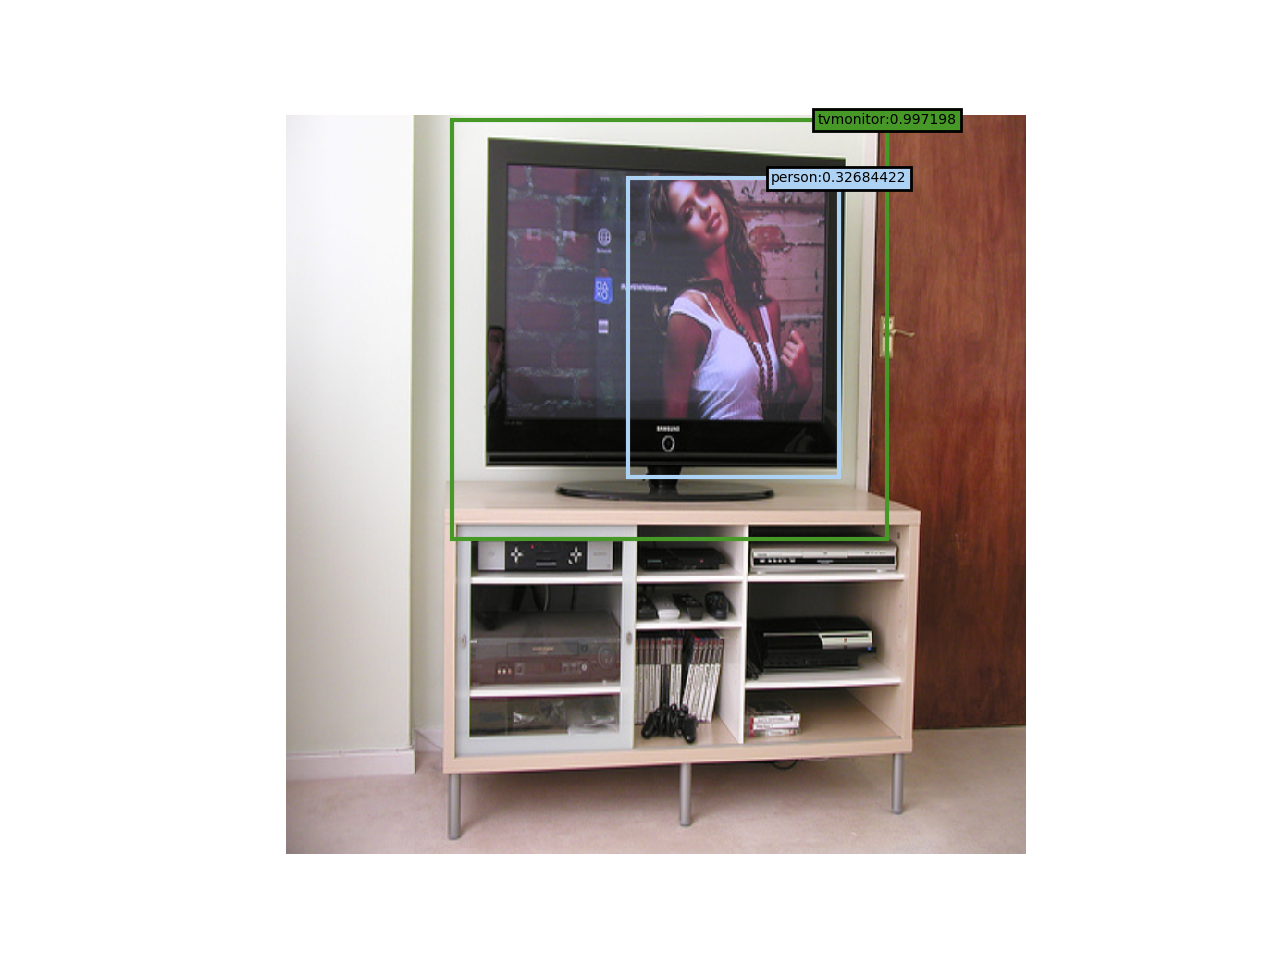

In [20]:
myimshow_score(images, res)

# Evaluate the model

In [50]:
import evaluation_voc
model = exp2.net
model.eval()
recall, precision, aps = evaluation_voc.run(model,val_set,device,thr = 0.5)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
---class aeroplane ap 0---
---class bicycle ap 0.5090008256805434---
---class bird ap 0.3277141504547701---
---class boat ap 0.1400813530602902---
---class bottle ap 0.16755692305029166---
---class bus ap 0.627509249896987---
---class car ap 0.45194141713025593---
---class cat ap 0.5974411146845271---
---class chair ap 0.1987518304297501---
---class cow ap 0.3857648384878389---
---class diningtable ap 0.2938115732931955---
---class dog ap 0.5662459596913779---
---class horse ap 0.5306230517534296---
---class motorbike ap 0.5870686601140912---
---class person ap 0.5046171802074361---
---class pottedplant ap 0.1420221564547731---
---class sheep ap 0.39991755334180074---
---class sofa ap 0.22966115161524497---
---class train ap 0.553632067762708---
---class tvmonitor ap 0.39549970597946715---
---map 0.3804430381544389---
time cost 2278.802449464798

In [25]:
import os
base_dir = os.getcwd()
file_name = os.path.join(base_dir, 'evaluation.txt')
my_open = open(file_name, 'a')
my_open.write('MobileNet\n')
my_open.write(str(aps))
my_open.write('\n')
my_open.close()

In [53]:
str(aps)

'[0, 0.5090008256805434, 0.3277141504547701, 0.1400813530602902, 0.16755692305029166, 0.627509249896987, 0.45194141713025593, 0.5974411146845271, 0.1987518304297501, 0.3857648384878389, 0.2938115732931955, 0.5662459596913779, 0.5306230517534296, 0.5870686601140912, 0.5046171802074361, 0.1420221564547731, 0.39991755334180074, 0.22966115161524497, 0.553632067762708, 0.39549970597946715]'